### Pytorch - classifier
- CNN을 활용한 모델을 만들어서 CIFAR-10에 대하여 정확도 95% 이상의 Classifier를 만드세요
- 예제 코드는 MNIST에 대한 코드

In [1]:
from matplotlib import pyplot as plt
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from tqdm import tqdm


torch.manual_seed(0) # seed 고정 - 여러번 실행해도 같은 결과가 나오도록 설정

#### Dataset download

In [2]:
# train_data = datasets.MNIST(
#     root = 'data',
#     train = True,                         
#     transform = ToTensor(), 
#     download = True,            
# )
# dataloader_train = DataLoader(train_data, 
#                               batch_size=16, 
#                               shuffle=True)

# test_data = datasets.MNIST(
#     root = 'data', 
#     train = False, 
#     transform = ToTensor()
# )
# dataloader_test = DataLoader(test_data, 
#                               batch_size=16, 
#                               shuffle=True)

# CIFAR10
train_data = datasets.CIFAR10(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
dataloader_train = DataLoader(train_data, 
                              batch_size=128, 
                              shuffle=True)

test_data = datasets.CIFAR10(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)
dataloader_test = DataLoader(test_data, 
                              batch_size=128, 
                              shuffle=True)


Files already downloaded and verified


#### Check images

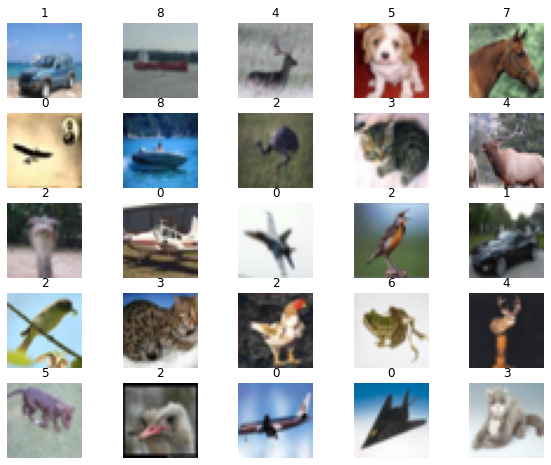

Data shape: torch.Size([3, 32, 32])


In [27]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0))
    # plt.imshow(img.squeeze(), cmap="gray")
plt.show()
print('Data shape:', img.shape)


#### CNN

In [4]:
class BasicBlock(nn.Module):
    # mul은 추후 ResNet18, 34, 50, 101, 152등 구조 생성에 사용됨
    mul = 1
    def __init__(self, in_planes, out_planes, stride=1):
        super(BasicBlock, self).__init__()
        
        # stride를 통해 너비와 높이 조정
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_planes)
        
        # stride = 1, padding = 1이므로, 너비와 높이는 항시 유지됨
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        
        # x를 그대로 더해주기 위함
        self.shortcut = nn.Sequential()
        
        # 만약 size가 안맞아 합연산이 불가하다면, 연산 가능하도록 모양을 맞춰줌
        if stride != 1: # x와 
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_planes)
            )
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x) # 필요에 따라 layer를 Skip
        out = F.relu(out)
        return out

In [5]:
class BottleNeck(nn.Module):
    # 논문의 구조를 참고하여 mul 값은 4로 지정, 즉, 64 -> 256
    mul = 4
    def __init__(self, in_planes, out_planes, stride=1):
        super(BottleNeck, self).__init__()
        
        #첫 Convolution은 너비와 높이 downsampling
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(out_planes)
        
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        
        self.conv3 = nn.Conv2d(out_planes, out_planes*self.mul, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_planes*self.mul)
        
        self.shortcut = nn.Sequential()
        
        if stride != 1 or in_planes != out_planes*self.mul:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes*self.mul, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_planes*self.mul)
            )
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = nn.ReLU()(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = nn.ReLU()(out)
        out = self.conv3(out)
        out = self.bn3(out)
        out += self.shortcut(x)
        out = nn.ReLU()(out)
        return out

In [6]:
class ResNet(nn.Module):
    # CIFAR-10을 학습시킬 것이므로, num_classes=10으로 설정
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        #RGB 3개채널에서 64개의 Kernel 사용
        self.in_planes = 64
        
        self.conv1 = nn.Conv2d(3, self.in_planes, kernel_size=7, stride=2, padding = 3)
        self.bn1 = nn.BatchNorm2d(self.in_planes)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self.make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self.make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self.make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self.make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        
        # Basic Resiudal Block일 경우 그대로, BottleNeck일 경우 4를 곱한다.
        self.linear = nn.Linear(512 * block.mul, num_classes)
        
    
    def make_layer(self, block, out_planes, num_blocks, stride):
        # layer 앞부분에서만 크기를 절반으로 줄이므로, 아래와 같은 구조
        strides = [stride] + [1] * (num_blocks-1)
        layers = []
        for i in range(num_blocks):
            layers.append(block(self.in_planes, out_planes, strides[i]))
            self.in_planes = block.mul * out_planes
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = nn.ReLU()(out)
        out = self.maxpool1(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out,1)
        out = self.linear(out)
        return out

In [16]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=16,
                               kernel_size=5,
                               stride=1,
                               padding=2)
        self.conv2 = nn.Conv2d(16, 64, 5, 1, 2)
        self.conv3 = nn.Conv2d(64, 256, 5, 1, 2)
        self.conv4 = nn.Conv2d(256, 512, 5, 1, 2)
        self.conv5 = nn.Conv2d(512, 1024, 5, 1, 2)
        self.maxpool = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.dropout = nn.Dropout(0.25)
        
        # fully connected layer, output 10 classes
        self.fc1 = nn.Linear(in_features=1024, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.dropout(x)
        
        x = self.conv2(x)
        x = self.maxpool(x)
        x = self.dropout(x)
        
        x = self.conv3(x)
        x = self.maxpool(x)
        x = self.dropout(x)
        
        x = self.conv4(x)
        x = self.maxpool(x)
        x = self.dropout(x)
        
        x = self.conv5(x)
        x = self.maxpool(x)
        x = self.dropout(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        x = nn.ReLU()(x)
        output = self.fc3(x)
        return output   # return x for visualization

#### Train

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# cnn = ResNet(BottleNeck, [3, 4, 6, 3]).to(device)
cnn = CNN().to(device)
cnn = torch.nn.DataParallel(cnn)
loss_func = nn.CrossEntropyLoss()   
optimizer = optim.Adam(cnn.parameters(), lr = 1e-4)

In [18]:
# Train the model
num_epochs = 20

for epoch in range(num_epochs):
    losses = list()
    for i, (images, labels) in enumerate(dataloader_train):
        images, labels = images.to(device), labels.to(device)
        output = cnn(images) 
        loss = loss_func(output, labels)

        # clear gradients for this training step   
        optimizer.zero_grad()           

        # backpropagation, compute gradients 
        loss.backward()    
        # apply gradients             
        optimizer.step()
        losses.append(loss.item())

        if (i+1) % 200 == 0:
            print ('Epoch [{}/{}], Step [{}], Loss: {:.4f}' 
                   .format(epoch + 1, num_epochs, i + 1, loss.item()))
    print ('Epoch [{}/{}], Loss: {:.4f}' 
                   .format(epoch + 1, num_epochs, sum(losses) / len(losses)))
    print("="*50)

Epoch [1/20], Step [200], Loss: 2.0327
Epoch [1/20], Loss: 1.9977
Epoch [2/20], Step [200], Loss: 1.7989
Epoch [2/20], Loss: 1.6969
Epoch [3/20], Step [200], Loss: 1.4940
Epoch [3/20], Loss: 1.5040
Epoch [4/20], Step [200], Loss: 1.3971
Epoch [4/20], Loss: 1.3753
Epoch [5/20], Step [200], Loss: 1.2125
Epoch [5/20], Loss: 1.2742
Epoch [6/20], Step [200], Loss: 1.1896
Epoch [6/20], Loss: 1.1927
Epoch [7/20], Step [200], Loss: 1.1564
Epoch [7/20], Loss: 1.1180
Epoch [8/20], Step [200], Loss: 0.9652
Epoch [8/20], Loss: 1.0543
Epoch [9/20], Step [200], Loss: 0.9957
Epoch [9/20], Loss: 0.9944
Epoch [10/20], Step [200], Loss: 0.9497
Epoch [10/20], Loss: 0.9410
Epoch [11/20], Step [200], Loss: 0.9390
Epoch [11/20], Loss: 0.8898
Epoch [12/20], Step [200], Loss: 0.9709
Epoch [12/20], Loss: 0.8426
Epoch [13/20], Step [200], Loss: 0.9656
Epoch [13/20], Loss: 0.7951
Epoch [14/20], Step [200], Loss: 0.8007
Epoch [14/20], Loss: 0.7514
Epoch [15/20], Step [200], Loss: 0.7039
Epoch [15/20], Loss: 0.707

#### Test

In [19]:
cnn.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in dataloader_test:
        images, labels = images.to(device), labels.to(device)
        test_output = cnn(images)
        pred_y = torch.max(test_output, 1)[1].data.squeeze() # max 를 통해 가장 확률이 높은 숫자를 선택
        correct += (pred_y == labels).sum().item() # 가장 확률이 높은 숫자인 pred_y와 label이 같으면 정답 - 정답인 개수 확인
        total += labels.size(0) 
    accuracy = correct / total * 100
    
print('Test Accuracy of the model on the 10000 test images: %.2f percent' % accuracy)

Test Accuracy of the model on the 10000 test images: 70.27 percent
